In [121]:
import numpy as np
import random
from pythreejs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Primitive elements

In [3]:
# create an instance of the line segment object
def ray(origin, direction, length, col):
  return Line(geometry=BufferGeometry(attributes={'position': BufferAttribute(array=np.array([origin, length * np.array(direction)]), normalized=False),}),material=LineBasicMaterial(color=col))

In [4]:
# create an instance of the box object
def point(position, col, size):
  return Points(geometry=BufferGeometry(attributes={"position": BufferAttribute(np.array([position]), normalized=False)}),
                material=PointsMaterial(color=col, size=size, sizeAttenuation=False))

In [5]:
# create an instance of the box object
def box(width, height, depth, position, col):
  box_geometry = BoxBufferGeometry(width=width, height=height, depth=depth)

  box_material = MeshPhysicalMaterial(color=col, transparent=True, opacity=0.5)
  box_mesh = Mesh(geometry=box_geometry, material=box_material)

  wireframe_material = LineBasicMaterial(color='#ff7070',linewidth=2)
  wireframe = WireframeGeometry(box_geometry)
  wireframe_mesh = LineSegments(wireframe, wireframe_material)

  box_group = Group(children=[box_mesh, wireframe_mesh])
  box_group.position = position

  return box_group

# Helper fuctions

In [6]:
# spherical to cartesian
def sph_car(theta, phi, r=1):
  x = r * np.sin(phi) * np.cos(theta)
  y = r * np.sin(phi) * np.sin(theta)
  z = r * np.cos(phi)
  return np.array([x, y, z])

In [61]:
def car_sph(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arccos(z / r)
    theta = np.arctan2(y, x)
    return theta, phi

In [7]:
# entry and exit points for a ray through an axis-aligned box
def intersect_ray_box(ray_origin, ray_direction, box_min, box_max):
    tnear = float('-inf')
    tfar = float('inf')

    for i in range(3):
        if ray_direction[i] == 0:
            if ray_origin[i] < box_min[i] or ray_origin[i] > box_max[i]:
                return None, None
        else:
            t1 = (box_min[i] - ray_origin[i]) / ray_direction[i]
            t2 = (box_max[i] - ray_origin[i]) / ray_direction[i]

            if t1 > t2:
                t1, t2 = t2, t1

            if t1 > tnear:
                tnear = t1

            if t2 < tfar:
                tfar = t2

            if tnear > tfar:
                return None, None

            if tfar < 0:
                return None, None

    return ray_origin + ray_direction * tnear, ray_origin + ray_direction * tfar

In [8]:
# takes two numpy arrays
def angle_between_vectors(a, b):
    return np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

I am going to be filling in the mathematically precise functions of theta and phi to replace the rough ones. For all, the only restrictions are that $\text{dir}$, or $\text{sph car}(\theta,\phi)$, is normalized. This can be ignored.

Distance Functions:

Back: $\frac{d}{\cos(\phi)}$

Left (+), Right (-): $\frac{\pm w}{2\sin(\phi)\cos(\theta)}-\frac{o}{\cos(\phi)}$

Top (+), Bottom (-): $\frac{\pm h}{2\sin(\phi)\sin(\theta)}-\frac{o}{\cos(\phi)}$

Their integrals, for future use:

Back: $d\ln|\tan(\phi)+\sec(\phi)|+C$


In [9]:
# my mathematically precise distance piecewise; still gotta get top and bottom and set up the trigger intervals
def dist(side):
  if side == 'back':
    # a pure function in and of itself
    return depth/np.cos(phi)
  elif side == 'right':
    # \frac{-w}{2sin(\phi)cos(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return width/(2*np.cos(angle_between_vectors(dir, np.array([-1,0,0]))))-origin/np.cos(phi)
  elif side == 'left':
    # \frac{w}{2sin(\phi)cos(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return width/(2*np.cos(angle_between_vectors(dir, np.array([1,0,0]))))-origin/np.cos(phi)
  elif side == 'top':
    # \frac{h}{2sin(\phi)sin(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return height/(2*np.cos(angle_between_vectors(dir, np.array([0,1,0]))))-origin/np.cos(phi)
  elif side == 'bottom':
    # \frac{-h}{2sin(\phi)sin(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return height/(2*np.cos(angle_between_vectors(dir, np.array([0,-1,0]))))-origin/np.cos(phi)
  else:
    return -1

In [10]:
# relationship between enery level and number of photons
def γ_num_by_MeV(MeV):
  return 1/(MeV+0.1)

In [11]:
# relationship between enery level and angle
def MeV_by_φ(MeV):
  return 5/(MeV**0.5+0.5)-1

In [55]:
# selects a random photon energy in the range of interest
def random_energy_level(MeV_range):
  n1 = (random.random()**0.5) * (MeV_range[1] - MeV_range[0]) + MeV_range[0]
  n2 = random.uniform(0,γ_num_by_MeV(MeV_range[0]))

  if n2 > γ_num_by_MeV(n1):
    return -1
  else:
    return n1

In [56]:
# takes a range of MeV we're interested in and outputs a corresponding θ and φ
def dir_from_γ_energy_range(range):
  MeV = random_energy_level(range)
  if MeV > 0:
    return random.uniform(0,2*np.pi), MeV_by_φ(MeV)
  else:
    return -1, -1

In [134]:
# calculate uniform-distribution average distance through target
def average_ray_length_uniform(samples):
    data = np.array([])

    for i in range(samples):
        theta = random.uniform(0,2*np.pi)
        phi = random.random()**0.5 * np.cos(phi_max)
        if theta >= 0:
            dir = sph_car(theta, phi)
            en, ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
            if en is not None and ex is not None:
                data = np.append(data, np.linalg.norm(en - ex))

    return np.mean(data)

# Interface

In [130]:
# parameters (θ is azimuthal, φ is polar)
origin = 3
width = 2
height = 5
depth = 7
box_min = np.array([-width / 2, -height / 2, origin])
box_max = np.array([width / 2, height / 2, depth + origin])
phi_max = np.arccos(origin / (np.sqrt(width**2/4 + height**2/4 + origin**2)))

In [135]:
# params for histogram
samples = 200000
bins = 200

# Rendering stuff

In [136]:
# histogram
data = np.array([])
phi_values = []
theta_values = []

for i in range(samples):
    theta, phi = dir_from_γ_energy_range((2.5, 20))
    if theta >= 0:
        dir = sph_car(theta, phi)
        en, ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
        if en is not None and ex is not None:
            data = np.append(data, np.linalg.norm(en - ex))
            phi_values.append(phi)
            theta_values.append(theta)

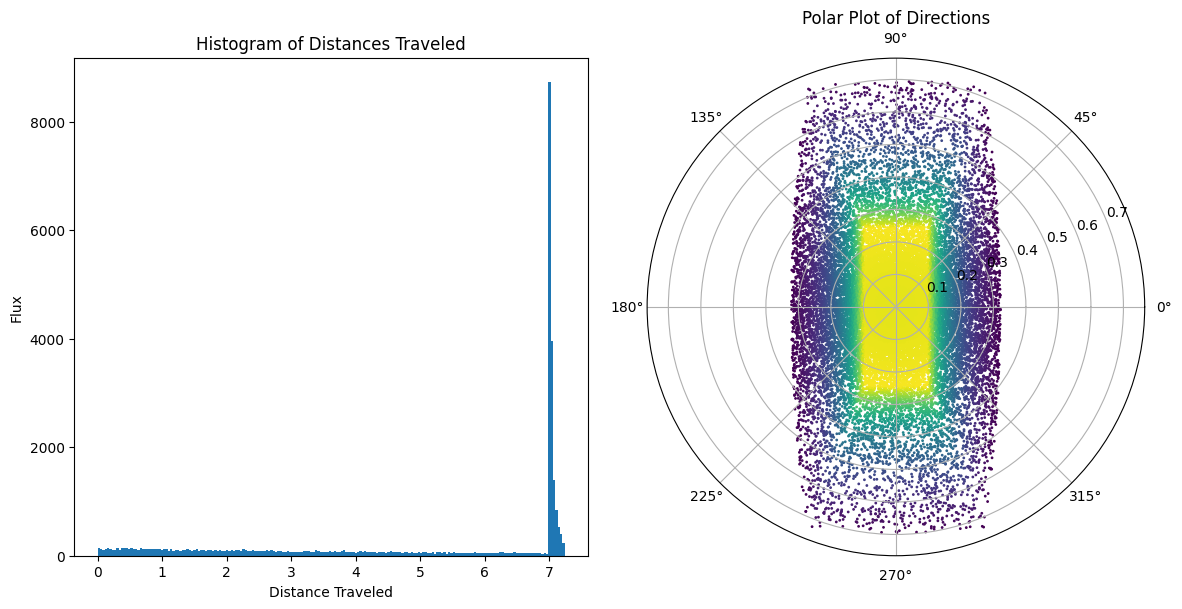

Mean Distance Traveled: 4.988366657196707


In [138]:
# Plot histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=bins)
plt.xlabel('Distance Traveled')
plt.ylabel('Flux')
plt.title('Histogram of Distances Traveled')

norm = colors.Normalize(vmin=0, vmax=7.3)
cmap = cm.viridis

point_colors = cmap(norm(data))

# Plot polar coordinates
plt.subplot(1, 2, 2, projection='polar')
plt.scatter(np.array(theta_values), np.array(phi_values), s=1, c=point_colors)
plt.title('Polar Plot of Directions')

plt.tight_layout()
plt.show()

# Print mean of the data
print("Mean Distance Traveled:", np.mean(data))

In [ ]:
# UI rendering
target_box = box(width, height, depth, (0, 0, depth / 2 + origin), 'red')

z_ray = ray(np.array([0, 0, 0]), sph_car(0, 0), 1, 'red')
y_ray = ray(np.array([0, 0, 0]), sph_car(np.pi/2, np.pi/2), 1, 'green')
x_ray = ray(np.array([0, 0, 0]), sph_car(0, np.pi/2), 1, 'blue')

rayy = ray(np.array([0, 0, 0]), sph_car(0.5,0.2), 1000, 'yellow')

origin_point = point([0, 0, 0], 'white', 4)

scene = Scene(children=[target_box, origin_point, x_ray, y_ray, z_ray, rayy])
scene.background = '#141414'

lights = [
    DirectionalLight(color='white', intensity=3, position=[0, 200, 0]),
    DirectionalLight(color='white', intensity=3, position=[100, 200, 100]),
    DirectionalLight(color='white', intensity=3, position=[-100, -200, -100])
]
for light in lights:
    scene.add(light)

camera = PerspectiveCamera(position=[10, 10, 10], up=[0, 1, 0], children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

display(Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], antialias=True, width=800, height=600))